# Prototype for testing Autoencoders as an approach for machine sound anomaly detection

This is a protype model performed on 6dB noise files of machine type 'valve' and machine id 'id_06'. The model requires further optimization. This is just to show the prooof of concept.

#### Note :
The notebook runs on the GPU of Google Colab. Running it on a local tensorflow version of a local machine might take significantly more time.

# Setting up the environment

In [1]:
import sys
import os
import shutil
import librosa
import glob
import tqdm

from librosa import display as ld

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import load, dump
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display as ipd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Mount google drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
!pwd

/gdrive


# Setting path to the Source scripts

In [4]:
sys.path += ['/gdrive/MyDrive/soundofsilence/src/filecheck', 
             '/gdrive/MyDrive/soundofsilence/src/preprocessing', 
             '/gdrive/MyDrive/soundofsilence/src/models']
             
from flatfielding import *
from filepath import *
from spectrogram import *
from conv_autoencoder import Autoencoder

# Data preprocessing

In [5]:
# Global variables
BASE = "/gdrive/MyDrive/soundofsilence/data"
SR = 16000

In [6]:
filepath = extract_filepath(BASE, inst='valve', id='id_06', cond='train')

In [7]:
filepath

['/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000001.wav',
 '/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000003.wav',
 '/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000002.wav',
 '/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000004.wav',
 '/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000005.wav',
 '/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000000.wav',
 '/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000006.wav',
 '/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000009.wav',
 '/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000010.wav',
 '/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000008.wav',
 '/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000014.wav',
 '/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000015.wav',
 '/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_0

In [8]:
"""# Check shape of all the files under my target dir
# Print only the unique shapes. Helps to see if all
# audio files are of same shape or not
file_shape, SR = check_data_shape(filepath, sr=None)
print("Sampling rate={}".format(SR))
print("Unique data shapes={}".format(file_shape))"""

'# Check shape of all the files under my target dir\n# Print only the unique shapes. Helps to see if all\n# audio files are of same shape or not\nfile_shape, SR = check_data_shape(filepath, sr=None)\nprint("Sampling rate={}".format(SR))\nprint("Unique data shapes={}".format(file_shape))'

# Trim or zero pad audio

The audio files are required to be of same length. 

Here I choose a length of 10 s and trip the audios to that length if they are longer or zero pad them (i.e. add silence) if they are of shorter duration.

In [9]:
# Add zero-padding or trimming to audio files
# Under the hood it creates a new dir 'flatfield'
# and stores preproocessed files under it
flatfield_audio(filepath, target_T=10, sr=SR)

Path Exists. Removing and adding...
File: /gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000001.wav
Zero padding or trimming not required...
File: /gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000003.wav
Zero padding or trimming not required...
File: /gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000002.wav
Zero padding or trimming not required...
File: /gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000004.wav
Zero padding or trimming not required...
File: /gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000005.wav
Zero padding or trimming not required...
File: /gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000000.wav
Zero padding or trimming not required...
File: /gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000006.wav
Zero padding or trimming not required...
File: /gdrive/MyDrive/soundofsilence/data/valve/id_06/train/normal_00000009.wav
Zero padding or trimming not required

# Create Spectrograms

In [10]:
trim_path = extract_filepath(BASE, inst='valve', id='id_06', cond='train', extradir='flatfield')

In [11]:
# Function for spectrogram generation

def plot_example_spectrogram(audio_file, 
                             typ,
                             n_mels,
                             n_fft,
                             hop_length,
                             power,
                             window):    

    y, sr = librosa.load(audio_file, sr=None, mono=True)

    mel_spectro = librosa.feature.melspectrogram(y=y,
                                                    sr=sr,
                                                    n_fft=n_fft,
                                                    hop_length=hop_length,
                                                    n_mels=n_mels,
                                                    power=power, 
                                                    window=window)

    log_mel_spectrogram = librosa.power_to_db(mel_spectro, ref=np.max)
      
    fig, ax = plt.subplots()
    plt.title("Example spectrogram of {} audio".format(typ))
    img = ld.specshow(log_mel_spectrogram, 
                    x_axis='time', 
                    y_axis='mel', 
                    sr=SR, 
                    fmax=8000, 
                    ax=ax)

    fig.colorbar(img, ax=ax)
    plt.show()
    plt.close()

### Spectrogram of a normal machine sound

In [12]:
sample_normal = '/gdrive/MyDrive/soundofsilence/data/valve/id_04/train/flatfield/normal_00000000.wav'
ipd.Audio(sample_normal)

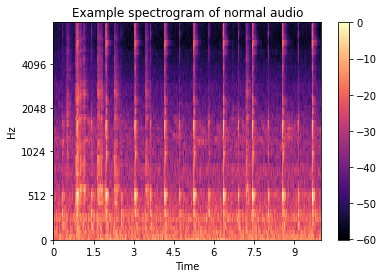

In [13]:
plot_example_spectrogram(sample_normal, 
                         typ='normal',
                         n_mels=64,
                         n_fft=1024,
                         hop_length=512,
                         window='hann',
                         power=2)

### Spectrogram of an anomalous machine sound

In [14]:
sample_anomaly = '/gdrive/MyDrive/soundofsilence/data/valve/id_04/test/abnormal_00000000.wav'
ipd.Audio(sample_anomaly)

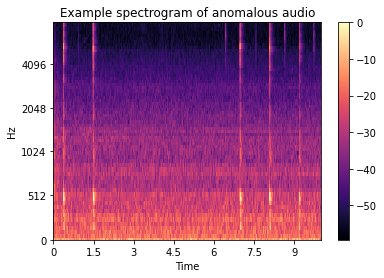

In [15]:
plot_example_spectrogram(sample_anomaly, 
                         typ='anomalous',
                         n_mels=64,
                         n_fft=1024,
                         hop_length=512,
                         window='hann',
                         power=2)

# Dense autoencoder

In [16]:
n_mels = 64
frames = 5
n_fft = 1024
hop_length = 512 
power = 2.0
window = 'hann'

dims = n_mels * frames

### Generate feature vector for Dense Autoencoder

In [17]:
# Mel spectrogram of individual audio

def spectrogram_block(file, n_fft, n_mels, 
                      hop_length, power, window, frames):
  """
  Creates feature vector for one spectrogram.
  file (str): input audio
  n_fft (int): no. of FFT windows
  n_mels (int): no. of Mel bands
  hop_length (int): hop of sliding 
                    window for STFT
  power (int): 1 or 2
  window (str): window func for STFT
  frames (int): Window size of features
  """

  y, sr = librosa.load(file, sr=None, mono=True)

  mel_spectrogram = librosa.feature.melspectrogram(y,
                                                   n_fft=n_fft,
                                                   n_mels=n_mels,
                                                   hop_length=hop_length,
                                                   window=window,
                                                   power=power)
  
  log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)
  
  n_dims = n_mels * frames

  block_size = len(log_mel_spectrogram[0, :]) - frames + 1

  feature_array = np.zeros(shape=(block_size, n_dims))

  for i in range(frames):
    feature_array[:, i * n_mels : (i+1) * n_mels] = log_mel_spectrogram[:, i : i + block_size].T

  #print("Shape of individual feature block", feature_array.shape)
  return feature_array


# mel spectrogram for a list of audios

def spectrogram_list(filelist, n_fft, 
                     n_mels, hop_length, 
                     power, window, frames):
  """
  Creates feature vector for all Audio files.
  filelist (str): input audio files
  n_fft (int): no. of FFT windows
  n_mels (int): no. of Mel bands
  hop_length (int): hop of sliding 
                    window for STFT
  power (int): 1 or 2
  window (str): window func for STFT
  frames (int): Window size of features
  """

  for i, file in tqdm.tqdm(enumerate(filelist), total=len(filelist)):

    transposed_spectrogram = spectrogram_block(file,
                                               n_fft,
                                               n_mels,
                                               hop_length,
                                               power,
                                               window,
                                               frames)
    
    if i==0:
      feature_map = np.zeros(shape=(len(filelist) * 
                                    transposed_spectrogram.shape[0], 
                                    transposed_spectrogram.shape[1]
                                    ))
      
    feature_map[i * transposed_spectrogram.shape[0] : 
                (i+1) * transposed_spectrogram.shape[0], :] = transposed_spectrogram

  return feature_map

### Generate training data

In [18]:
train_data = spectrogram_list(trim_path, 
                  n_mels=n_mels, 
                  n_fft=n_fft, 
                  hop_length=hop_length, 
                  window=window, 
                  power=power, 
                  frames=frames)

train_data.shape

100%|██████████| 872/872 [00:12<00:00, 70.12it/s]


(269448, 320)

### Visualize training data

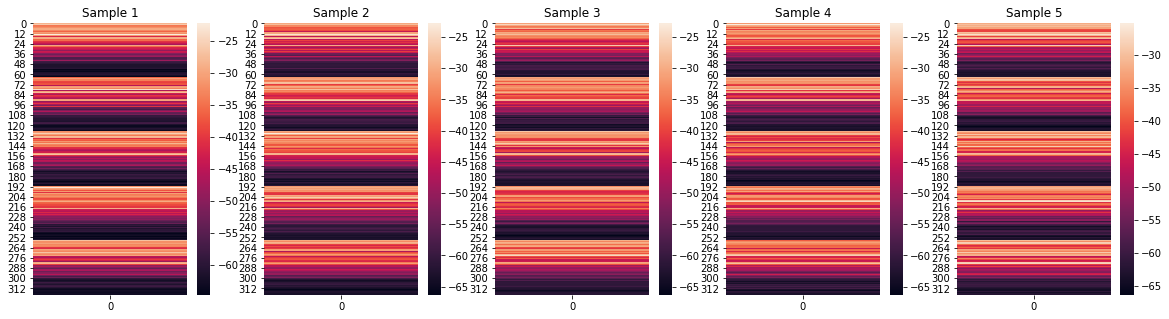

In [19]:
def plot_train_data_dense(train_data):
  """
  Plot 5 samples of the training data
  """
  fig, ax = plt.subplots(1, 5, figsize=(20, 5))

  for idx in range(5):
    sample = train_data[idx]

    ax[idx].set_title("Sample {}".format(idx + 1))
    sns.heatmap(sample.reshape(320, 1), ax=ax[idx])
    
  plt.show()
  plt.close()


# Plot train data
plot_train_data_dense(train_data=train_data)

### Build Dense Autoencoder model

In [20]:
def tensorflow_model(inputdim):
  model_input = layers.Input(shape=(inputdim,))
  y = layers.Dense(64, activation='relu')(model_input)
  y = layers.Dense(64, activation='relu')(y)
  y = layers.Dense(8, activation='relu')(y)
  y = layers.Dense(64, activation='relu')(y)
  y = layers.Dense(64, activation='relu')(y)
  y = layers.Dense(inputdim, activation=None)(y)

  model = Model(inputs=model_input, outputs=y)
  print(model.summary())
  return model

In [21]:
model = tensorflow_model(320)

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(train_data,
                    train_data,
                    epochs=50,
                    batch_size=512,
                    validation_split=0.1,
                    shuffle=True,
                    verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                20544     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 320)               20800 

### Loss curves

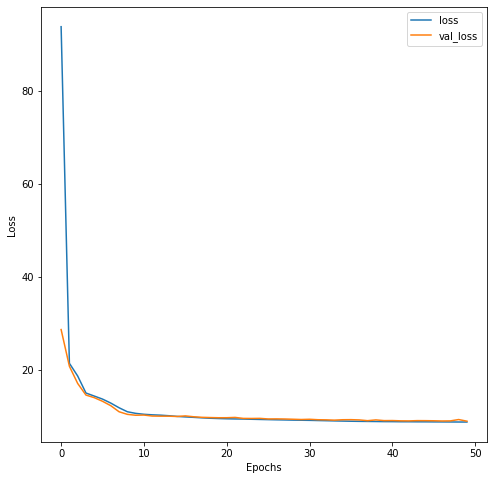

In [22]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.close()

### Model validation

In [23]:
# Model evaluation on test data

def test_files(base, inst, id, cond):
  """
  Return the path to test files

  base (str) : Data directory
  inst (str) : Instrument
  id (str) : Instrument Id
  cond (str) : Instrument condition

  return:
  testpath : Path to test files
  test_file_list : Names of test files
  """
  testpath = extract_filepath(base, inst, id, cond)

  test_file_list = [file.split('/')[-1].split('_')[0] 
                    for file in testpath]

  return testpath, test_file_list



def reconstruction_error(testpath, test_file_list):
  """
  Return reconstruction loss of Dense autoencoder

  test_file_list (list) : All test data
  """
  y_true = [0 if name=='normal' else 1 
              for name in test_file_list]

  y_pred = np.zeros(shape=len(y_true))

  for i, file in tqdm.tqdm(enumerate(testpath), total=len(testpath)):

    test_data = spectrogram_list([file], 
                    n_mels=n_mels, 
                    n_fft=n_fft, 
                    hop_length=hop_length, 
                    window=window, 
                    power=power, 
                    frames=frames)
    
    pred_data = model.predict(test_data)

    squared_error = np.square(test_data - pred_data)
    featurewise_error = np.mean(squared_error, axis=1)
    reconstruction_error = np.mean(featurewise_error)


    y_pred[i] = reconstruction_error
    return y_true, y_pred

In [24]:
# Reconstruction error of test data
testpath, test_file_list = test_files(base=BASE, 
                                       inst='valve', 
                                       id='id_06', 
                                       cond='test')

y_true, y_pred = reconstruction_error(testpath, test_file_list)

  0%|          | 0/240 [00:00<?, ?it/s]


In [25]:
auc_score = metrics.roc_auc_score(y_true, y_pred)
print("Roc AUC score={}".format(auc_score))

Roc AUC score=0.49583333333333335


# Convolutional autoencoder

In [26]:
n_mels = 128
frames = 5
n_fft = 1024
hop_length = 512
power = 2.0
window = 'hann'
dim = 32
step = 8

### Normalizing Mel spectrograms

In [27]:
scaler = fit_scaler(filelist=trim_path, 
                    n_fft=n_fft, 
                    n_mels=n_mels, 
                    hop_length=hop_length, 
                    window=window, 
                    power=power,
                    scaler_dir='scaler',
                    scaler=StandardScaler())

  1%|          | 7/872 [00:00<00:13, 62.09it/s]

Fitting StandardScaler(copy=True, with_mean=True, with_std=True) to train data in /gdrive/MyDrive/soundofsilence/data/valve/id_06/train/flatfield


100%|██████████| 872/872 [00:13<00:00, 64.26it/s]


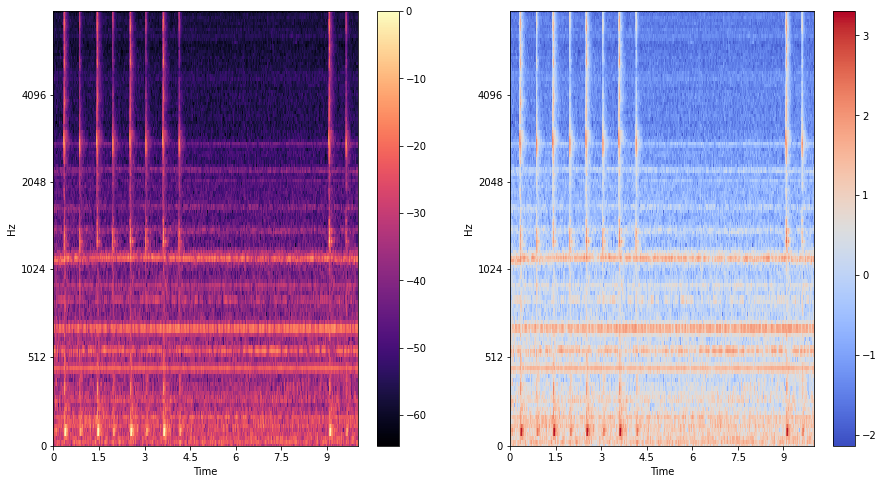

In [28]:
def plot_spect_scaling(scaler, audio_sample):

    y, sr = librosa.load(audio_sample, sr=None, mono=True)

    mel_spectro = librosa.feature.melspectrogram(y=y,
                                                  sr=sr,
                                                  n_fft=n_fft,
                                                  hop_length=hop_length,
                                                  n_mels=n_mels,
                                                  power=power, 
                                                  window=window)

    unscaled_log_mel_spectrogram = librosa.power_to_db(mel_spectro, ref=np.max)

    scaled_log_mel_spectrogram = scaler.transform(unscaled_log_mel_spectrogram)

    speclist = [unscaled_log_mel_spectrogram, 
                        scaled_log_mel_spectrogram]
      
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))

    for i, spectrogram in  enumerate(speclist):
                        img = ld.specshow(spectrogram, 
                        x_axis='time', 
                        y_axis='mel', 
                        sr=SR, 
                        fmax=8000, 
                        ax=ax[i])

                        fig.colorbar(img, ax=ax[i])
    plt.show()
    plt.close()

# Plot scaled and unscaled spectrograms
sample = '/gdrive/MyDrive/soundofsilence/data/valve/id_06/train/flatfield/normal_00000001.wav'

plot_spect_scaling(scaler=scaler,
                   audio_sample=sample)

### Generate train features for Convolutional Autoencoders

In [29]:
trial_batch = mel_spectrogram(file=sample, 
                                scaler=scaler, 
                                n_fft=n_fft, 
                                n_mels=n_mels, 
                                hop_length=hop_length, 
                                window=window, 
                                power=power, 
                                dim=dim, 
                                step=step)

trial_batch.shape

(37, 32, 128)

### Visualize training data

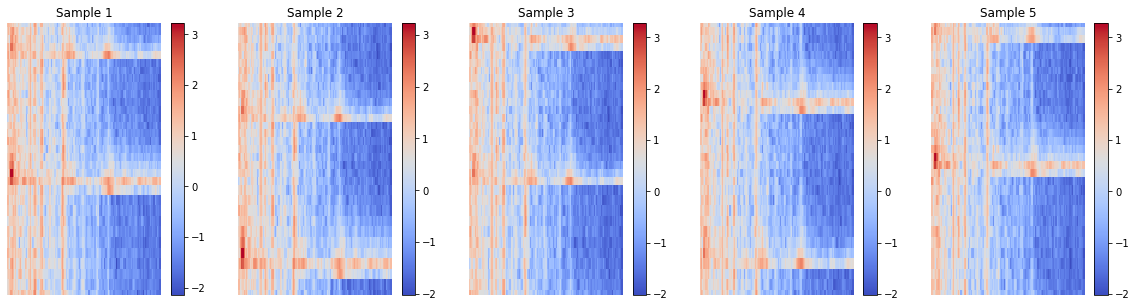

In [30]:
def plot_train_data_dense(train_data):
  """
  Plot 5 samples of the training data
  """
  fig, ax = plt.subplots(1, 5, figsize=(20, 5))

  for idx in range(5):
    sample = train_data[idx]

    ax[idx].set_title("Sample {}".format(idx + 1))
    img = ld.specshow(sample, 
                        x_axis='time', 
                        y_axis='mel', 
                        sr=SR, 
                        fmax=8000, 
                        ax=ax[idx])

    fig.colorbar(img, ax=ax[idx])
    ax[idx].axis('off')
    
  plt.show()
  plt.close()


# Plot train data
plot_train_data_dense(train_data=trial_batch)

In [31]:
# Test the trial_spectrogram_list function
trial_spectro_list = mel_spectrogram_list(filelist=[sample, sample, ], 
                                      out_dir='features', 
                                      scaler_dir='scaler',
                                      n_fft=n_fft, 
                                      n_mels=n_mels, 
                                      hop_length=hop_length, 
                                      window=window, 
                                      power=power, 
                                      dim=dim, 
                                      step=step)

trial_spectro_list.shape

100%|██████████| 2/2 [00:00<00:00, 36.91it/s]


(74, 32, 128, 1)

In [32]:
# Generate train data for Conv AE
train_data = mel_spectrogram_list(filelist=trim_path, 
                                      out_dir='features', 
                                      scaler_dir='scaler',
                                      n_fft=n_fft, 
                                      n_mels=n_mels, 
                                      hop_length=hop_length, 
                                      window=window, 
                                      power=power, 
                                      dim=dim, 
                                      step=step)

100%|██████████| 872/872 [01:19<00:00, 10.91it/s]


In [33]:
train_data.shape

(32264, 32, 128, 1)

### Build Convolutional Autoencoder

In [34]:
class Autoencoder:
    """
    A Deep Convolutional Autoencoder
    """
    def __init__(self,
                 input_shape,
                 num_nodes,
                 num_kernel,
                 num_strides,
                 latent_dim):

        self.input_shape = input_shape
        self.num_nodes = num_nodes
        self.num_kernel = num_kernel
        self.num_strides = num_strides
        self.latent_dim = latent_dim

        self.num_layers = len(self.num_nodes)
        self._model_input = None
        self.shape_before_flatten = None

        self.encoder = None
        self.decoder = None
        self.model = None
        print("This is my autoencoder")

        self.build_network()


    def summary(self):
        self.encoder.summary()
        print("Shape before flatten={}".format(self.shape_before_flatten))
        self.decoder.summary()
        self.model.summary()


    def build_network(self):
        """
        Build the complete Autoencoder
        """
        self.build_encoder()
        self.build_decoder()
        self.build_model()

    ######################## ENCODER ###########################

    def build_encoder(self):
        """
        Build the encoder architecture
        """
        enc_input = self.build_encoder_input()

        enc_conv = self.build_encoder_convs(enc_input)

        enc_latent = self.build_encoder_latent(enc_conv)

        self._model_input = enc_input

        self.encoder = Model(enc_input, enc_latent,
                             name="Encoder")


    def build_encoder_input(self):
        """
        Build the input layer of Encoder
        """

        return layers.Input(shape=self.input_shape,
                            name="Encoder_input")


    def build_encoder_convs(self, enc_inp_layer):
        """
        Build the convolutional layers.
        As many layers as the 'num_layers'.
        """
        stack_layer = enc_inp_layer

        for layer_index in range(self.num_layers):
            stack_layer = self.build_encoder_conv(layer_index,
                                                  stack_layer)
        return stack_layer


    def build_encoder_conv(self, layer_ind, layer):
        """
        Build one particular Convolutional layer,
        Activation Function and Regularization.
        """
        # Convolutional layers
        X = layers.Conv2D(filters=self.num_nodes[layer_ind],
                          kernel_size=self.num_kernel[layer_ind],
                          strides=self.num_strides[layer_ind],
                          padding="same",
                          name="Conv_enc{}".format(layer_ind))(layer)

        # Batch Normalization
        X = layers.BatchNormalization(name="BatchNorm_enc{}"
                                      .format(layer_ind))(X)

        # ReLU activation function
        X = layers.ReLU(name="ReLU_enc{}".format(layer_ind))(X)

        return X


    def build_encoder_latent(self, conv_output):
        """
        Build the latent dimensional space.
        Embeds the features from the Conv2D layers
        into a lower dimensional space.
        """
        self.shape_before_flatten = K.int_shape(conv_output)[1:]

        """X = layers.Conv2D(filters=self.latent_dim,
                          kernel_size=(5,5),
                          strides=(6, 6),
                          padding='same'
                          )(conv_output)"""

        #X = layers.Flatten(name="Flatten_enc")(X)
        X = layers.Flatten(name="Flatten_enc")(conv_output)

        X = layers.Dense(self.latent_dim, name="Latent_enc")(X)

        return X
    ################################################################

    ######################## DECODER ###############################

    def build_decoder(self):
        """
        Build the decoder architecture
        """

        dec_input = self.build_decoder_input()
        dec_dense = self.build_decoder_dense(dec_input)
        dec_reshape = self.build_decoder_reshape(dec_dense)
        dec_conv = self.build_decoder_convs(dec_reshape)
        dec_output = self.build_decoder_output(dec_conv)

        self.decoder = Model(dec_input, dec_output,
                             name='Decoder')

    def build_decoder_input(self):
        """
        Input layer of decoder of shape latent_dim
        """
        decoder_input_layer =  layers.Input(
            shape=(self.latent_dim,),
            name="decoder_input")

        return decoder_input_layer


    def build_decoder_dense(self, decoder_input):
        """
        Dense layer after embedding space
        Shape should be the 'combined' array
        of Encoder before flattening i.e.
        np.prod(self.shape_before_flatten)
        """
        decoder_dense_shape = np.prod(self.shape_before_flatten)
        """decoder_dense_shape = self.shape_before_flatten[1] * \
                              self.shape_before_flatten[2] * \
                              self.shape_before_flatten[3]"""

        decoder_dense = layers.Dense(decoder_dense_shape,
                                     name="Decoder_dense")(decoder_input)
        return decoder_dense


    def build_decoder_reshape(self, decoder_dense):
        """
        Reshape Layer after Flattening to feed in
        to the Conv2DTranspose layer.
        """
        reshaped = layers.Reshape(self.shape_before_flatten)
        return reshaped(decoder_dense)


    def build_decoder_convs(self, decoder_reshape):
        """
        Build all the Conv2DTranspose layers
        of shape equal to number of layers
        excluding the first.
        """
        stack_layer_dec = decoder_reshape

        for layer_index in reversed(range(0, self.num_layers-1)):
        #for layer_index in range(0, self.num_layers-1):
            stack_layer_dec = self.build_decoder_conv(layer_index,
                                                      stack_layer_dec)
        return stack_layer_dec


    def build_decoder_conv(self, layer_ind, X):
        """
        Build individual Conv2DTranspose layer of
        the Decoder.
        """
        dec_convlayer_num = self.num_layers - layer_ind

        conv_trans = layers.Conv2DTranspose(filters=self.num_nodes[layer_ind],
                                           kernel_size=self.num_kernel[layer_ind],
                                           strides=self.num_strides[layer_ind+1],
                                           padding="same",
                                           name="Decoder_ConvTrans{}"
                                           .format(dec_convlayer_num)
                                           ) 
        X = conv_trans(X)

        X = layers.BatchNormalization(name="Decoder_BatchNorm{}"
                                      .format(dec_convlayer_num))(X)

        X = layers.ReLU(name="Decoder_ReLU{}"
                        .format(dec_convlayer_num))(X)

        return X


    def build_decoder_output(self, X):
        """
        Output layer of the decoder
        """
        decoder_outlayer = layers.Conv2DTranspose(filters=1,
                                                  kernel_size=self.num_kernel[0],
                                                  strides=self.num_strides[0],
                                                  padding="same",
                                                  name="Decoder_output")
        X =  decoder_outlayer(X)
        #decoder_final = layers.Activation("sigmoid", name="Decoder_activation")
        return X  #decoder_final(X)

    ######################## AUTOENCODER #######################################
    def build_model(self):
        """
        Build the Autoencoder model
        combining encoder and decoder
        """
        model_input = self._model_input
        encoder_output = self.encoder(model_input)
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)

In [35]:
"""autoencoder = Autoencoder(input_shape=(32, 128, 1),
                              num_nodes=[32, 64, 128, 256, 512],
                              num_kernel=[5, 5, 5, 3, 3],
                              num_strides=[(2, 2), (1, 2), (1, 2), (2, 2), (2, 2)],
                              latent_dim=40
                              )"""

autoencoder = Autoencoder(input_shape=(32, 128, 1),
                              num_nodes=[32, 64, 128, 256,],
                              num_kernel=[5, 5, 3, 3],
                              num_strides=[(1, 2), (2, 2), (2, 2), (1, 2),],
                              latent_dim=20
                              )
                            

print(autoencoder.summary())

This is my autoencoder
Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_input (InputLayer)   [(None, 32, 128, 1)]      0         
_________________________________________________________________
Conv_enc0 (Conv2D)           (None, 32, 64, 32)        832       
_________________________________________________________________
BatchNorm_enc0 (BatchNormali (None, 32, 64, 32)        128       
_________________________________________________________________
ReLU_enc0 (ReLU)             (None, 32, 64, 32)        0         
_________________________________________________________________
Conv_enc1 (Conv2D)           (None, 16, 32, 64)        51264     
_________________________________________________________________
BatchNorm_enc1 (BatchNormali (None, 16, 32, 64)        256       
_________________________________________________________________
ReLU_enc1 (ReLU)             (None, 

### Model training

In [36]:
model = autoencoder.model

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(train_data,
                    train_data,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.1,
                    shuffle=True,
                    verbose=1)

Epoch 1/30
454/454 [==============================] - 45s 32ms/step - loss: 0.2541 - val_loss: 0.0999
Epoch 2/30
454/454 [==============================] - 14s 31ms/step - loss: 0.0908 - val_loss: 0.0992
Epoch 3/30
454/454 [==============================] - 14s 31ms/step - loss: 0.0803 - val_loss: 0.0863
Epoch 4/30
454/454 [==============================] - 14s 32ms/step - loss: 0.0770 - val_loss: 0.0972
Epoch 5/30
454/454 [==============================] - 14s 32ms/step - loss: 0.0752 - val_loss: 0.0878
Epoch 6/30
454/454 [==============================] - 14s 31ms/step - loss: 0.0742 - val_loss: 0.0801
Epoch 7/30
454/454 [==============================] - 14s 31ms/step - loss: 0.0734 - val_loss: 0.0794
Epoch 8/30
454/454 [==============================] - 14s 31ms/step - loss: 0.0727 - val_loss: 0.0754
Epoch 9/30
454/454 [==============================] - 14s 31ms/step - loss: 0.0721 - val_loss: 0.0768
Epoch 10/30
454/454 [==============================] - 14s 31ms/step - loss: 0.071

### Loss curves

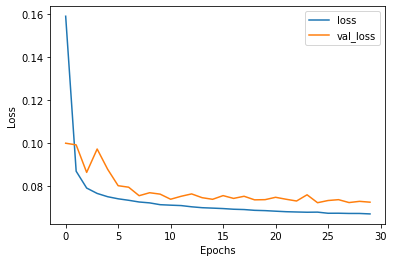

In [37]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.close()

### Model evaluation

In [39]:
# Test reconstruction loss

testpath, test_file_list = test_files(base=BASE, 
                                       inst='valve', 
                                       id='id_06', 
                                       cond='test')

#y_true, y_pred = reconstruction_error(testpath, test_file_list)#

testpath = extract_filepath(BASE, inst='valve', id='id_06', cond='test')

test_file_list = [file.split('/')[-1].split('_')[0] for file in testpath]

y_true = [0. if name=='normal' else 1. for name in test_file_list]

y_pred = np.zeros(shape=len(y_true))

for i, file in tqdm.tqdm(enumerate(testpath), total=len(testpath)):
  test_data = mel_spectrogram(file=file, 
                                scaler=scaler, 
                                n_fft=n_fft, 
                                n_mels=n_mels, 
                                hop_length=hop_length, 
                                window=window, 
                                power=power, 
                                dim=dim, 
                                step=step)
  
  
  test_data = test_data.reshape((test_data.shape[0], 
                                 test_data.shape[1], 
                                 test_data.shape[2], 
                                 1))
  
  pred_data = model.predict(test_data)

  squared_error = np.square(test_data - pred_data)
  featurewise_error = np.mean(squared_error, axis=-1)
  reconstruction_error = np.mean(featurewise_error)

  y_pred[i] = reconstruction_error

100%|██████████| 240/240 [00:22<00:00, 10.84it/s]


In [40]:
# Train reconstruction loss

trainpath, train_file_list = test_files(base=BASE, 
                                       inst='valve', 
                                       id='id_06', 
                                       cond='train/flatfield')

#y_true_trn, y_pred_trn = reconstruction_error(trainpath, train_file_list)

trnpath = extract_filepath(BASE, inst='valve', id='id_06', cond='train', extradir='flatfield')

train_file_list = [file.split('/')[-1].split('_')[0] for file in trnpath]

y_true_trn = [0. if name=='normal' else 1. for name in train_file_list]

y_pred_trn = np.zeros(shape=len(y_true_trn))

for i, file in tqdm.tqdm(enumerate(trnpath), total=len(trnpath)):
  trn_data = mel_spectrogram(file=file, 
                                scaler=scaler, 
                                n_fft=n_fft, 
                                n_mels=n_mels, 
                                hop_length=hop_length, 
                                window=window, 
                                power=power, 
                                dim=dim, 
                                step=step)
  
  
  trn_data = trn_data.reshape((trn_data.shape[0], 
                                 trn_data.shape[1], 
                                 trn_data.shape[2], 
                                 1))
  
  pred_trn = model.predict(trn_data)

  squared_error = np.square(trn_data - pred_trn)
  featurewise_error = np.mean(squared_error, axis=-1)
  reconstruction_error = np.mean(featurewise_error)

  y_pred_trn[i] = reconstruction_error

100%|██████████| 872/872 [01:08<00:00, 12.67it/s]


In [41]:
auc_score = metrics.roc_auc_score(y_true, y_pred)
print("Roc AUC score={}".format(auc_score))

Roc AUC score=0.9219444444444443


### Reconstruction loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


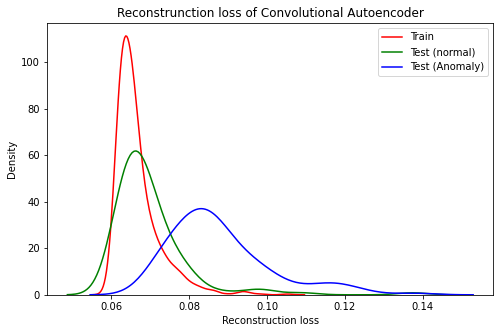

In [42]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.title("Reconstrunction loss of Convolutional Autoencoder")

# Extract reconstruction loss from predicted labels
y_pred_normal = y_pred[[np.array(y_true) == 0]]
y_pred_anomaly = y_pred[np.array(y_true) == 1]


sns.kdeplot(y_pred_trn, 
             ax=ax, 
             label='Train', 
             color='red',
             alpha=0.5,
            common_norm=True
            )

sns.kdeplot(y_pred_normal, 
             ax=ax, 
             label='Test (normal)',
             color='green', 
             alpha=0.5,
            common_norm=True)

sns.kdeplot(y_pred_anomaly, 
             ax=ax, 
             label='Test (Anomaly)',
             color='blue', 
             alpha=0.5,
            common_norm=False)


plt.legend()
plt.xlabel('Reconstruction loss')
#plt.xlim(0.05, 0.12)
#plt.xscale('log')
plt.show()
plt.close()